In [1]:
# Imported Libraries
import pennylane as qml
from pennylane.optimize import AdamOptimizer
from pennylane import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from graphs import plot_correlation_matrix
import random

import torch
from torchvision import datasets, transforms

In [2]:
import sys
sys.path.append("..") # Adds higher directory to python modules path
sys.path.append 

from qencode.initialize import setAB_amplitude, setAux, setEnt
from qencode.encoders import e2_classic
from qencode.training_circuits import swap_t
from qencode.qubits_arrangement import QubitsArrangement

from qencode.utils.mnist import get_dataset

In [3]:
!pip install kaggle

In [4]:
df = pd.read_csv('creditcard.csv')

First, we import the credit card data set. We are only going to print the first 5 rows because the dataset contains over 280,000 rows. Each row represents a transaction. Time shows the time passed between the current and first transactions and amount shows the dollar amount spent on the transaction. There are also 28 more features represented by V1, V2, ... , V28 which come from principal component analysis. Finally, there is the class, where a '0' represents no fraud committed and a '1' represents a fraudulent transaction

Let's now check the class distribution

In [5]:
print('No Frauds: ', df['Class'].value_counts()[0])
print('Frauds: ', df['Class'].value_counts()[1])

No Frauds:  247128
Frauds:  449


Credit card fraud is relatively rare, this creates a very imbalanced distribution. A very imbalanced distribution is not ideal as this can lead to overfitting and our model assuming no fraud most of the time. It is also challenging to find the true correlations between the features and class.

In [6]:
plot_correlation_matrix(df, "Original")

In [7]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# Scaling amount and time for the subsample
df['scaled_amount'] = RobustScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = RobustScaler().fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)


scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)



df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.709533,-1.004264,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.0
1,-0.277350,-1.004264,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.0
2,4.806761,-1.004251,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0.0
3,1.356322,-1.004251,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.0
4,0.632725,-1.004238,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.0


In [8]:

df = df.sample(frac=1)
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
sub_sample_df = normal_distributed_df.sample(frac=1, random_state=42)

sub_sample_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
42635,-0.159838,-0.467626,-7.334341,4.960892,-8.451410,8.174825,-7.237464,-2.382711,-11.508842,4.635798,...,0.723314,2.153755,0.033922,-0.014095,0.625250,-0.053390,0.164709,1.411047,0.315645,1.0
91039,0.584043,-0.179557,1.091962,-0.249256,0.478365,0.608838,-0.539472,-0.142405,-0.182566,0.076721,...,0.004077,-0.241423,-0.719681,-0.018433,0.030088,0.291904,0.283943,-0.041650,0.011545,0.0
150667,0.741041,0.218846,-10.850282,6.727466,-16.760583,8.425832,-10.252697,-4.192171,-14.077086,7.168288,...,-0.646818,2.541637,0.135535,-1.023967,0.406265,0.106593,-0.026232,-1.464630,-0.411682,1.0
6108,0.484111,-0.913228,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,...,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,1.0
150662,3.960243,0.218755,-5.839192,7.151532,-12.816760,7.031115,-9.651272,-2.938427,-11.543207,4.843627,...,0.055684,2.462056,1.054865,0.530481,0.472670,-0.275998,0.282435,0.104886,0.254417,1.0


In [9]:
sub_sample_corr = sub_sample_df.corr()
plot_correlation_matrix(sub_sample_corr, "Sub Sample Correlation Matrix")

Find the features with the strongest correlation to class. Half are the strongest positive correlations, half are the strongest negative correlations. 

In [10]:
def find_strongest_correlations(dataframe, qubits):
        
    class_correlations = dataframe.loc['Class', :]
    class_correlations = class_correlations.drop(index = 'Class')
    
    feature_list = list(class_correlations.index)
    correlation_list = [class_correlations[x] for x in feature_list]
    
    features = []
    correlations = []
    
    for i in range(int(qubits/2)):
        
        
        correlations.append(max(correlation_list))
        features.append(feature_list[correlation_list.index(max(correlation_list))])
        
        del feature_list[correlation_list.index(max(correlation_list))]
        del correlation_list[correlation_list.index(max(correlation_list))]                        
                                      
        correlations.append(min(correlation_list))
        features.append(feature_list[correlation_list.index(min(correlation_list))])
        
        del feature_list[correlation_list.index(min(correlation_list))]
        del correlation_list[correlation_list.index(min(correlation_list))] 
    
    return features, correlations
    
    
print(find_strongest_correlations(sub_sample_corr, 8))



(['V4', 'V14', 'V11', 'V12', 'V2', 'V10', 'V19', 'V16'], [0.7224944130082979, -0.7597213268619109, 0.7010988535241773, -0.6947929253418941, 0.5248640088571999, -0.6390742446261429, 0.27319075958066563, -0.6195809770643468])


In [11]:
feature_list, correlations = find_strongest_correlations(sub_sample_corr, 8)

#Create dataframe with only the features with the strongest correlations to class

#input_data = df[feature_list] 
#print(input_data.head)
#input_data.head()

In [12]:
# Dataframe of all non fraudulent transactions
branch = df
non_fraud = branch[branch["Class"]!="1"]

# All examples of non fraudulent data with 6 features
non_fraud = non_fraud[feature_list]
non_fraud.head()

input_data = non_fraud.to_numpy()

# Training 

In [13]:
shots = 2500
nr_trash= 2
nr_latent= 1
nr_ent=0

spec = QubitsArrangement(nr_trash, nr_latent, nr_swap=1, nr_ent=nr_ent)
print("Qubits:", spec.qubits)

#set up the device 
dev = qml.device("default.qubit", wires=spec.num_qubits)

Qubits: [0, 1, 2, 3, 4, 5]


In [14]:
@qml.qnode(dev)
def training_circuit_example(init_params, encoder_params, reinit_state):
    #initilaization
    setAB_amplitude(spec, init_params)

    setAux(spec, reinit_state)

    setEnt(spec, inputs=[1 / np.sqrt(2), 0, 0, 1 / np.sqrt(2)])

    #encoder

    for params in encoder_params:
        e2_classic(params, [*spec.latent_qubits, *spec.trash_qubits])

    #swap test 
    swap_t(spec)

    return [qml.probs(i) for i in spec.swap_qubits]

In [15]:
epochs = 1000
learning_rate = 0.0003
batch_size = 2
num_samples = 30 # proportion of the data used for training 

beta1 = 0.9
beta2 = 0.999
opt = AdamOptimizer(learning_rate, beta1=beta1, beta2=beta2)

In [16]:
def fid_func(output):
    # Implemented as the Fidelity Loss
    # output[0] because we take the probability that the state after the 
    # SWAP test is ket(0), like the reference state
    fidelity_loss = 1 / output[0]
    return fidelity_loss

In [17]:
def cost(encoder_params, X):
    reinit_state = [0 for i in range(2 ** len(spec.aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output = training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state)[0]
        f = fid_func(output)
        loss = loss + f
    return loss / len(X)

In [18]:
def fidelity(encoder_params, X):
    reinit_state = [0 for i in range(2 ** len(spec.aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output = training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state)[0]
        f = output[0]
        loss = loss + f
    return loss / len(X)

In [19]:
def iterate_batches(X, batch_size):
    
    random.shuffle(X)

    batch_list = []
    batch = []
    for x in X:
        if len(batch) < batch_size:
            batch.append(x)

        else:
            batch_list.append(batch)
            batch = []
    if len(batch) != 0:
        batch_list.append(batch)
    return batch_list

In [20]:
num_samples = .2 
num_samples = 40
#approach = df[df["Class"]!="1"]
#training_data = [ torch.tensor([input_data[i]]) for i in range(int(len(input_data)*num_samples))]
#test_data = [torch.tensor([input_data[i]]) for i in range(int(len(input_data)*num_samples),len(input_data))]

training_data = [ torch.tensor([input_data[i]]) for i in range(num_samples)]
test_data = [ torch.tensor([input_data[i]]) for i in range(num_samples,num_samples+num_samples)]

#training_data = [ torch.tensor([approach[i]]) for i in range(int(len(approach)*num_samples))]
#test_data = [torch.tensor([approach[i]]) for i in range(int(len(approach)*num_samples),len(input_data))]

/home/ec2-user/anaconda3/envs/Braket/lib/python3.7/site-packages/ipykernel/__main__.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


In [21]:
training_data[0]

tensor([[-2.5962, -0.2051, -0.2194, -0.7224, -1.6188,  1.5937, -0.2598, -0.7080]],
       dtype=torch.float64)

In [22]:
X_training = training_data
X_tes = test_data
'''
X1 = [torch.reshape(x[0], (1, 2 ** (len(spec.latent_qubits) + len(spec.trash_qubits)))) for x in training_data]
X2 = []
for i in range(len(X1)):
    X2.append([X1[1], training_data[i][1]])
X_training = X2

X1 = [torch.reshape(x[0], (1, 2 ** (len(spec.latent_qubits) + len(spec.trash_qubits)))) for x in test_data]
X2 = []
for i in range(len(X1)):
    X2.append([X1[1], training_data[i][1]])
X_tes = X2
'''

'\nX1 = [torch.reshape(x[0], (1, 2 ** (len(spec.latent_qubits) + len(spec.trash_qubits)))) for x in training_data]\nX2 = []\nfor i in range(len(X1)):\n    X2.append([X1[1], training_data[i][1]])\nX_training = X2\n\nX1 = [torch.reshape(x[0], (1, 2 ** (len(spec.latent_qubits) + len(spec.trash_qubits)))) for x in test_data]\nX2 = []\nfor i in range(len(X1)):\n    X2.append([X1[1], training_data[i][1]])\nX_tes = X2\n'

In [23]:
# initialize random encoder parameters
nr_encod_qubits = len(spec.trash_qubits) + len(spec.latent_qubits)
nr_par_encoder =  15 * int(nr_encod_qubits*(nr_encod_qubits-1)/2)
encoder_params = np.random.uniform(size=(1, nr_par_encoder), requires_grad=True)

In [24]:
#fraud = df[df["Class"]=="1"]
fraud = fraud_df[feature_list]
np_fraud = fraud.to_numpy()
fraud_data = [ torch.tensor([np_fraud[i]]) for i in range(len(fraud.to_numpy()))]

fraud.head()


,V4,V14,V11,V12,V2,V10,V19,V16
30496,5.252842,-8.604759,3.657350,-7.781448,5.649439,-7.833556,1.645414,-6.553973
152019,1.710314,-0.673818,2.175230,-4.381078,4.107873,-6.625692,2.594453,-4.254927
235644,3.121459,-6.745561,1.927186,-6.011155,3.846800,-5.175660,0.971906,-4.325132
44556,3.616119,-7.245550,3.586824,-6.636229,3.353451,-5.699922,0.936940,-6.856810
144104,3.891160,-8.149322,4.221304,-6.119667,2.928541,-5.995676,2.355919,-5.375283


In [25]:
"""
loss_hist=[]
fid_hist=[]

loss_hist_test=[]
fid_hist_test=[]

fraud_fid=[]

for epoch in range(epochs):
    batches = iterate_batches(X=training_data, batch_size=batch_size)
    for xbatch in batches:
        encoder_params = opt.step(cost, encoder_params, X=xbatch)

        
    if epoch%5 == 0:
        
        loss_training = cost(encoder_params, X_training )
        fidel = fidelity(encoder_params, X_training )
        
        loss_hist.append(loss_training)
        fid_hist.append(fidel)
        print("Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_training, fidel))

        loss_test = cost(encoder_params, X_tes )
        fidel = fidelity(encoder_params, X_tes )
        loss_hist_test.append(loss_test)
        fid_hist_test.append(fidel)
        print("Test-Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_test, fidel))
        
        f_fidel = fidelity(encoder_params, fraud_data )
        fraud_fid.append(f_fidel)
        print("Fraud Fidelity:{}".format(f_fidel))
"""

'\nloss_hist=[]\nfid_hist=[]\n\nloss_hist_test=[]\nfid_hist_test=[]\n\nfraud_fid=[]\n\nfor epoch in range(epochs):\n    batches = iterate_batches(X=training_data, batch_size=batch_size)\n    for xbatch in batches:\n        encoder_params = opt.step(cost, encoder_params, X=xbatch)\n\n        \n    if epoch%5 == 0:\n        \n        loss_training = cost(encoder_params, X_training )\n        fidel = fidelity(encoder_params, X_training )\n        \n        loss_hist.append(loss_training)\n        fid_hist.append(fidel)\n        print("Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_training, fidel))\n\n        loss_test = cost(encoder_params, X_tes )\n        fidel = fidelity(encoder_params, X_tes )\n        loss_hist_test.append(loss_test)\n        fid_hist_test.append(fidel)\n        print("Test-Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_test, fidel))\n        \n        f_fidel = fidelity(encoder_params, fraud_data )\n        fraud_fid.append(f_fidel)\n        print("Frau

In [26]:
encoder_params=[[-0.45793534, -0.60180382,  1.36706854, -0.39273726,  0.78967496,
         -0.11834691,  1.21601293,  0.7257659 ,  0.16775198,  0.87110514,
          0.5825973 ,  1.35786832,  1.6198694 , -0.21858262,  1.41542989,
          1.2968311 ,  1.8630585 ,  0.50511886,  0.75524677,  0.82482716,
          1.02949018, -0.023521  ,  0.55110408,  0.15877528,  0.62316124,
          0.37113699,  0.4557925 ,  0.62940097,  0.61549768,  0.95122916,
          0.22349399,  0.86457997,  0.81546047,  1.47984623,  1.72818011,
         -0.30175269,  0.67999145, -0.22226086,  0.94370564,  1.48028116,
          0.72720142,  0.20210445,  0.14995309,  0.19133051, -0.35101019,
          0.40932117, -0.09846242,  0.65960454,  0.78151562,  1.17058629,
          0.23858532,  0.71485483,  0.31327769,  1.63693523,  0.95525645,
          0.58935465,  0.76165831,  0.62729872,  0.55561916,  0.19378356,
          0.41408805,  1.01374824,  0.37282255, -0.06769513,  0.45583351,
         -0.05101048,  0.83344398,  1.58156091,  1.46059524,  0.9371276 ,
          0.96522386,  0.27626285,  0.19818911,  0.11227637,  0.38220371,
          0.64166103,  0.92703234,  0.3736458 ,  0.21161801,  0.62412085,
          0.3278856 , -0.18893975,  0.86769553,  0.78573112,  0.50142613,
          0.96622037,  0.40300401,  0.55802604,  0.12912973,  0.14822851]]

In [27]:
branch = df 
non_fraud_df = branch.loc[branch["Class"]!=1][:200]


non_fraud = non_fraud_df[feature_list]
np_non_fraud = non_fraud.to_numpy()
non_fraud_data = [ torch.tensor([np_non_fraud[i]]) for i in range(len(non_fraud.to_numpy()))]

non_fraud_flist=[]
for b in non_fraud_data:
    f=fidelity(encoder_params, [b])
    non_fraud_flist.append(f.item())
    
print(min(non_fraud_flist))
print(max(non_fraud_flist))


0.5044869319102099
0.8322707087812675


In [28]:
#np_ilegal= ilegal.to_numpy()
#ilegal_data = [ torch.tensor([np_ilegal[i]]) for i in range(len(ilegal.to_numpy()))]
fraud_df = branch.loc[branch["Class"]==1][:200]
non_fraud = fraud_df[feature_list]
np_non_fraud = non_fraud.to_numpy()
fraud_data = [ torch.tensor([np_non_fraud[i]]) for i in range(len(non_fraud.to_numpy()))]



fraud_flist=[]
for b in fraud_data:
    f=fidelity(encoder_params, [b])
    fraud_flist.append(f.item())
    
print(min(fraud_flist))
print(max(fraud_flist))


0.5256371817626905
0.8314060213631194


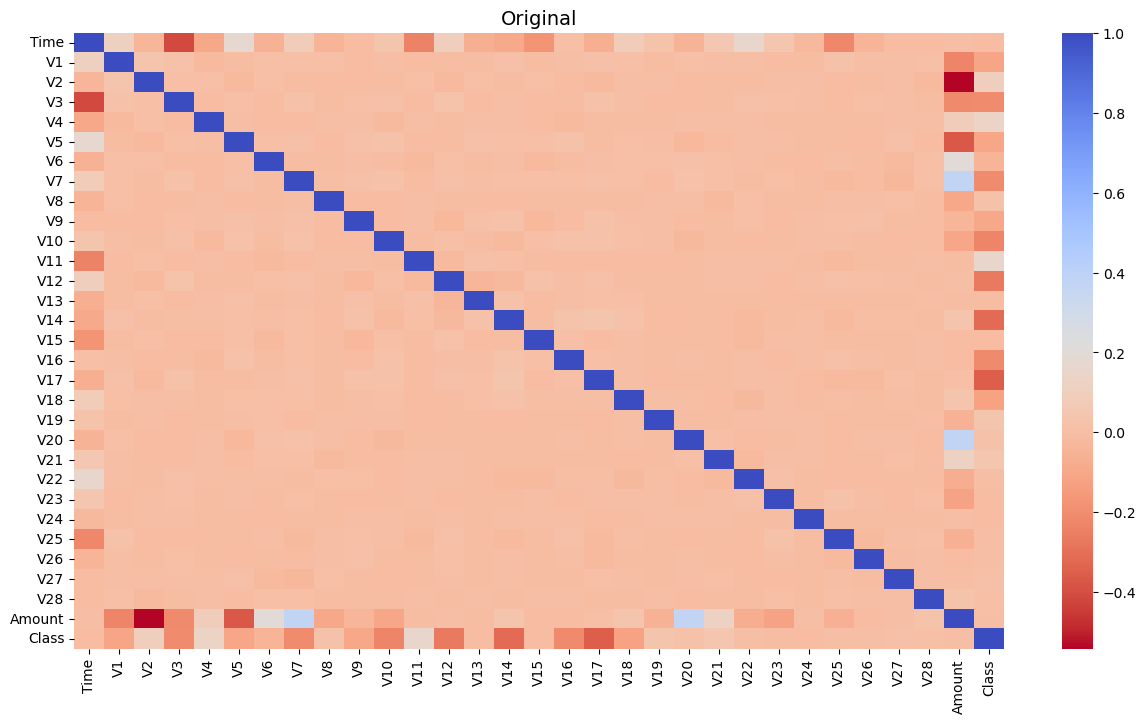

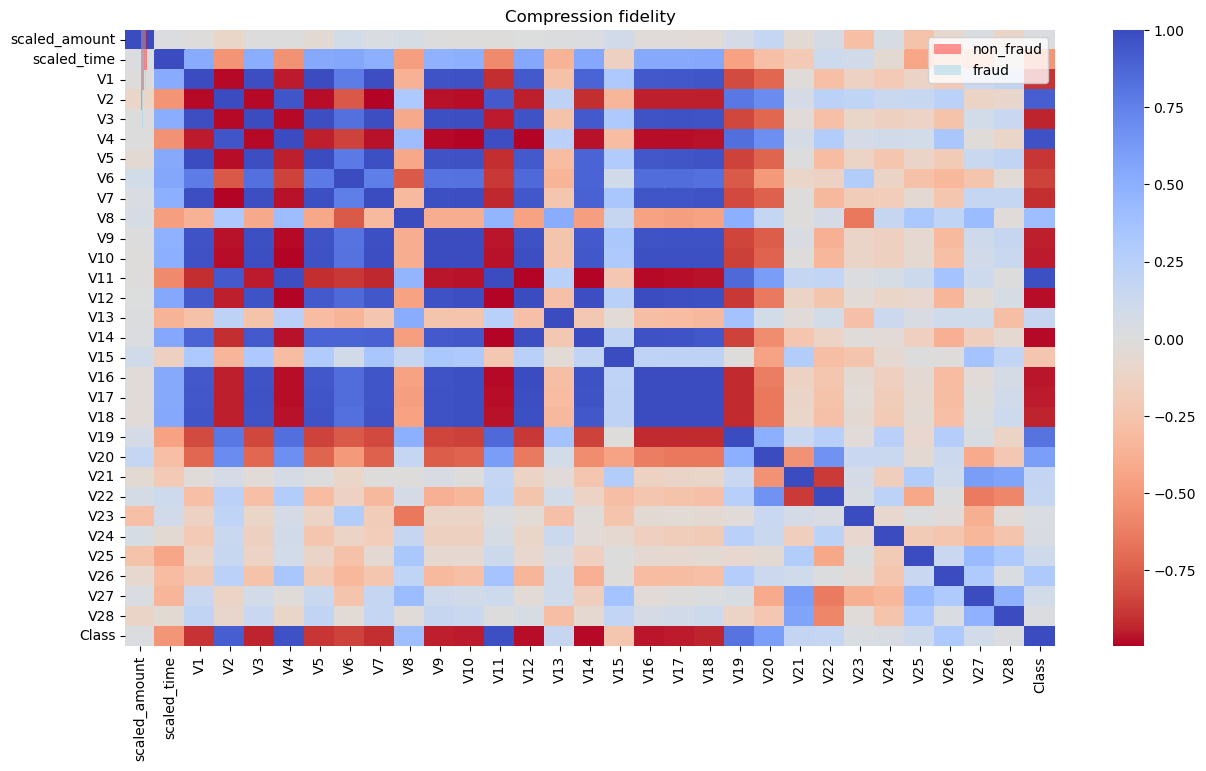

In [29]:
plt.hist(non_fraud_flist, bins =100 ,label="non_fraud",color = "red",alpha=0.4)
plt.hist(fraud_flist, bins = 100 ,label="fraud", color = "skyblue",alpha=0.4)
plt.title("Compression fidelity",)
plt.legend()
plt.savefig("Compression_fidelity")
plt.show()


## Real Real

In [30]:
device_rigetti = "arn:aws:braket:::device/qpu/rigetti/Aspen-11"

# Note: please change the s3 directory accordingly based on your account if you want to run the code
my_bucket = f"amazon-braket-e2ddc0be70c2" # the name of the bucket
my_prefix = "e5results" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [32]:
qubits= [0, 1, 2, 3, 4, 5]

dev_rigetti_aws = qml.device('braket.aws.qubit', device_arn=device_rigetti, shots=2500*2, wires=qubits, s3_destination_folder=s3_folder)



In [33]:
@qml.qnode(dev)
def training_circuit_example_(init_params, encoder_params, reinit_state):
    #initilaization
    setAB_amplitude(spec, init_params)

    setAux(spec, reinit_state)

    setEnt(spec, inputs=[1 / np.sqrt(2), 0, 0, 1 / np.sqrt(2)])

    #encoder

    for params in encoder_params:
        e2_classic(params, [*spec.latent_qubits, *spec.trash_qubits])

    #swap test 
    swap_t(spec)

    return [qml.probs(i) for i in spec.swap_qubits]


def fidelity(encoder_params, X):
    reinit_state = [0 for i in range(2 ** len(spec.aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output = training_circuit_example_(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state)[0]
        f = output[0]
        loss = loss + f
    return loss / len(X)

In [34]:
branch = df 
non_fraud_df = branch.loc[branch["Class"]!=1][:200]


non_fraud = non_fraud_df[feature_list]
np_non_fraud = non_fraud.to_numpy()
non_fraud_data = [ torch.tensor([np_non_fraud[i]]) for i in range(len(non_fraud.to_numpy()))]

non_fraud_flist=[]
for b in non_fraud_data:
    f=fidelity(encoder_params, [b])
    non_fraud_flist.append(f.item())
    
print(min(non_fraud_flist))
print(max(non_fraud_flist))

0.5044869319102099
0.8322707087812675


In [35]:
#np_ilegal= ilegal.to_numpy()
#ilegal_data = [ torch.tensor([np_ilegal[i]]) for i in range(len(ilegal.to_numpy()))]
fraud_df = branch.loc[branch["Class"]==1][:200]
non_fraud = fraud_df[feature_list]
np_non_fraud = non_fraud.to_numpy()
fraud_data = [ torch.tensor([np_non_fraud[i]]) for i in range(len(non_fraud.to_numpy()))]



fraud_flist=[]
for b in fraud_data:
    f=fidelity(encoder_params, [b])
    fraud_flist.append(f.item())
    
print(min(fraud_flist))
print(max(fraud_flist))

0.5256371817626905
0.8314060213631194


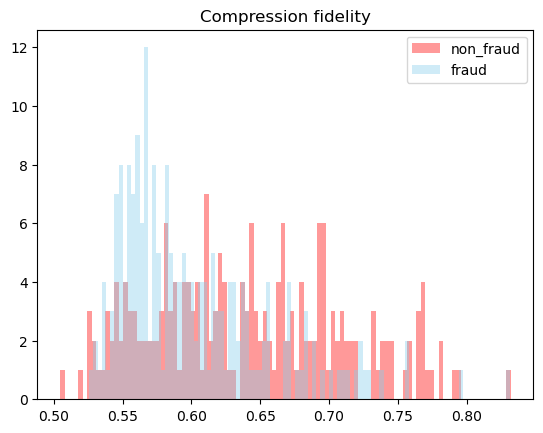

In [36]:
plt.hist(non_fraud_flist, bins =100 ,label="non_fraud",color = "red",alpha=0.4)
plt.hist(fraud_flist, bins = 100 ,label="fraud", color = "skyblue",alpha=0.4)
plt.title("Compression fidelity",)
plt.legend()
plt.savefig("Compression_fidelity")
plt.show()